# About

Main purpose of this notebook is to get our data loaded into Torch such that we can start experimenting with NN

Following:
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [1]:
%matplotlib inline

import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Dataset Class

Lets load our csv into our dataset class and do a quick sanity check to see if our data is correct.

In [25]:
class HandDataset(Dataset):
    """3D Hand Pose dataset"""
    
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to csv file
            transform (callable, optional): Optional transform to be applied
        """
        self.csv = pd.read_csv(csv_file)
        self.transform = transform
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, idx):
        img_name = df.iloc[idx,0]
        image = io.imread(img_name)
        
        pos_3d = df.iloc[idx, 1:(21*3)+1].as_matrix()
        pos_3d = pos_3d.reshape(21,3)

        pos_2d = df.iloc[idx, (21*3)+1:].as_matrix()
        pos_2d = pos_2d.reshape(21,2)
        
        sample = {'image': image,
                  'pos_3d': pos_3d,
                  'pos_2d': pos_2d}
        
        if self.transform:
            sample = self.transform(sample)
        return sample
            
handDataset = HandDataset('dataset.csv')

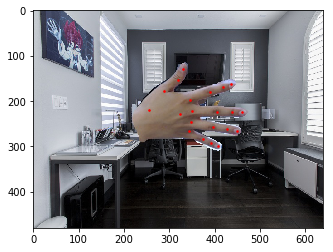

In [34]:
sample = handDataset[np.random.randint(len(handDataset))]

def show_joints(fig, image, pos_2d, pos_3d):
    plt.imshow(image)
    plt.scatter(pos_2d[:,0], pos_2d[:, 1], s=10, marker='.', c='r')
    
    
fig = plt.figure()
show_joints(fig, sample['image'], sample['pos_2d'], sample['pos_3d'])
plt.show()